Example for tobac application: Tracking of meso-scale GPM precipitation features
===

This example notebook demonstrates the use of tobac to track features of contiguous precipitation areas at meso-scale (~100 km horizontal dimension). The main difference from this notebook to the other examples is that tracking is performed based on high resolution data over a long time period, which means that feature detection and sementation must be performed for monthly data chunks and then recombined to one dataframe, in order to conduct the trajectory linking. 

The data used in this example can be downloaded from the NASA GES DISC platform (note that an open account is needed to get the data): 
https://disc.gsfc.nasa.gov/datasets/GPM_3IMERGHH_V06/


**Data product** : GPM IMERG, v06 , netCDF4 format

**Resolution**: 30 min, 0.1 x 0.1 degrees

**Subset**: 2014 - 2018, for region of the Tibetan Plateau (27.0 - 45.0 N, 70.0- 105.0 E)          

*Note that temporal and spatial subsets can be created directly at the GES DISC platform*

**Import necessary python libraries:**

In [1]:
# Import libraries
import iris
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt
import datetime
import urllib,zipfile,shutil
from netCDF4 import Dataset
import glob
%matplotlib inline

In [2]:
# Import tobac itself
import tobac
from tobac import utils

In [4]:
# Disable a few warnings:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

## Data download using wget

 

In [13]:
# define output directory
data_dir='/media/juli/Data/third_pole/satellite_data/gpm_v06/'
# variable name in netCDF file 
param= 'precipitationCal'
# name of file with link list 
url = 'url.txt'
# go to data directory where the link list (url.txt) for your subset is located
!cd $data_dir

In [73]:
# download link list from GES DISC and use the following command to download the data

!wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --auth-no-challenge=on --keep-session-cookies --content-disposition -i $url

## Data preparation

Aggregation into monthly files for each year and setting time axis and calendar, in order to use the downloaded netCDF files with tobac. 

**! Note:** In order to prepare the data, so it can be used for tobac, the command-line program CDO (Climate Data Operators) needs to be installed.


In [12]:
# make sure you have the bash script located in your data folder 
!ls *sh

tobac_prepare.sh


In [51]:
import subprocess
 # Call a bash script
subprocess.call(['./tobac_prepare.sh'])

0

In [28]:
#Set up directory to save output and plots:
import os
savedir=data_dir + 'Save'
os.makedirs(savedir,exist_ok=True)
plotdir=data_dir + 'Plot'
os.makedirs(plotdir,exist_ok=True)

# Define parameters for feature detection, segmentation and tracking


## Feature detection 

In [78]:
# Dictionary containing keyword options (could also be directly given to the function)
parameters_features={}
parameters_features['position_threshold']='weighted_diff' # diff between specific value and threshold for weighting when finding the center location (instead of just mean lon/lat)
parameters_features['min_num']=3 #? 
parameters_features['min_distance']=0 # minimum distance between features 

parameters_features['sigma_threshold']=0.5 # for slightly smoothing (gaussian filter)
parameters_features['n_erosion_threshold']=0 # pixel erosion (for more robust results)

parameters_features['threshold']=[1,2,3,4,5,7,10,15] #mm/h, step-wise threshold for feature detection 
parameters_features['n_min_threshold']=10 # minimum nr of contiguous pixels for thresholds, 10 pixels = ca. 2000 km2


## Segmentation 

In [12]:
# Dictionary containing keyword arguments for segmentation step:
parameters_segmentation={}
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']=1  # mm/h mixing ratio (until which threshold the area is taken into account)

## Tracking

In [69]:
# read in one test file and define spacing 
data_file= '2014/gpm_imerg_201406_tobac_input.nc4'
Precip=iris.load_cube(data_file,'precipitationCal')
Precip.attributes = None
dxy,dt=tobac.get_spacings(Precip)

In [21]:
# Dictionary containing keyword arguments for the linking step:
parameters_linking={}
parameters_linking['adaptive_stop']=0.2
parameters_linking['adaptive_step']=0.95
parameters_linking['extrapolate']=0
parameters_linking['order']=1
parameters_linking['subnetwork_size']= 1000 # maximum size of subnetwork used for linking 
parameters_linking['memory']=0
parameters_linking['time_cell_min']= dt 
parameters_linking['method_linking']='predict'
parameters_linking['v_max']= 10
parameters_linking['d_min']=4*dxy # four times the grid spacing 

# Perform feature detection and segmentation with monthly data chunks

In [83]:
# get list with all files by month
import glob
file_list= glob.glob(data_dir + '/*tobac_input.nc4')  
print('files in dataset:  ', len(file_list))

files in dataset:   50


In [ ]:
for file in file_list:
    i = file[107:113]
    print('start process for file.....', file)
    ## DATA PREPARATION
    Precip=iris.load_cube(file, param)
    dxy,dt=tobac.get_spacings(Precip)
    
    # FEATURE DETECTION
    print('starting feature detection based on multiple thresholds')
    Features=tobac.feature_detection_multithreshold(Precip,dxy,**parameters_features)
    print('feature detection done')
    Features.to_hdf(os.path.join(savedir,'Features' + str(i) + '.h5'),'table')
    print('features saved')
    
    # SEGMENTATION 
    print('Starting segmentation based on surface precipitation')
    Mask,Features_Precip=tobac.segmentation_2D(Features,Precip,dxy,**parameters_segmentation)
    print('segmentation based on surface precipitation performed, start saving results to files')
    iris.save([Mask],os.path.join(savedir,'Mask_Segmentation_precip' + str(i) + '.nc'),zlib=True,complevel=4)                
    Features_Precip.to_hdf(os.path.join(savedir,'Features_Precip' + str(i) + '.h5'),'table')
    print('segmentation surface precipitation performed and saved')

# Trajectory linking

In [110]:
# read in HDF5 files with saved features
file_list= glob.glob(savedir  + '/Features_Precip??????.h5')  
file_list.sort()
print('nr. of monthly feature files:', len(file_list))

nr. of monthly feature files: 50


## Recombination of dataframes with update of frame number

! When recombining the dataframes of feature chunks by month into one large dataframe, it is important to make sure to update the frame numbers !

In [111]:
i = 0 
frames = 0 

for file in file_list: 
    if i == 0:
        Features = pd.read_hdf(file, 'table')
        # read in data mask with segments for tracked cells 
        date= file[len(file)-9: len(file)-3]
        ds = Dataset(savedir+ '/Mask_Segmentation_precip'+date+'.nc')
        mask = np.array(ds['segmentation_mask'])  
        # update total nr of frames 
        frames += np.shape(mask)[0] -1
        i = 1 
        print('file for: ',date, 'rows: ',features.shape[0], 'frames: ', frames)

    features = pd.read_hdf(file, 'table')
    # update frame number and make sure they are sequential
    features['frame'] = features['frame']  + frames
    # append dataframes 
    Features = Features.append(features, ignore_index=True)      
    # read in data mask with segments for tracked cells 
    date= file[len(file)-9: len(file)-3]
    ds = Dataset(savedir+ '/Mask_Segmentation_precip'+date+'.nc')
    mask = np.array(ds['segmentation_mask'])  
    #update total nr of frames
    frames += np.shape(mask)[0]
    print('file for: ',date, 'rows: ',features.shape[0], 'frames: ', frames)

file for:  201403 rows:  8646 frames:  959
file for:  201403 rows:  8008 frames:  1919
file for:  201404 rows:  13305 frames:  3359
file for:  201405 rows:  18581 frames:  4847
file for:  201406 rows:  31526 frames:  6287
file for:  201407 rows:  41579 frames:  7775
file for:  201408 rows:  40352 frames:  9263
file for:  201409 rows:  26948 frames:  10703
file for:  201410 rows:  11100 frames:  12191
file for:  201411 rows:  6641 frames:  13631
file for:  201412 rows:  3678 frames:  15119
file for:  201501 rows:  8337 frames:  16607
file for:  201502 rows:  8646 frames:  17951
file for:  201503 rows:  14169 frames:  19439
file for:  201504 rows:  18801 frames:  20879
file for:  201505 rows:  21525 frames:  22367
file for:  201506 rows:  35233 frames:  23807
file for:  201507 rows:  35844 frames:  25295
file for:  201508 rows:  41418 frames:  26783
file for:  201509 rows:  23520 frames:  28223
file for:  201510 rows:  10736 frames:  29711
file for:  201511 rows:  7567 frames:  31151
fil

## Perform tracking with merged features 

In [204]:
Track=tobac.linking_trackpy(Features,Precip,dt=dt,dxy=dxy,**parameters_linking)
Track.to_hdf(os.path.join(savedir,'Tracks_GPM_2014-2018.h5'),'table')

Frame 72455: 36 trajectories present.


# Some examples for analysis and visualisation...

In [72]:
Tracks[Tracks.ncells == 0]

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,longitude,latitude,ncells,cell,time_cell
734,135,1,3.174335,65.814960,24,1,735,2014-03-14 19:30:00,2014-03-14 19:30:00,70.367432,33.531495,0,462.0,02:00:00
736,135,11,15.618929,134.398612,30,1,737,2014-03-14 19:30:00,2014-03-14 19:30:00,71.611895,40.389861,0,487.0,00:00:00
1184,173,12,29.980841,74.722609,11,1,1185,2014-03-15 14:30:00,2014-03-15 14:30:00,73.048087,34.422261,0,768.0,02:30:00
1609,234,1,4.365356,35.282629,44,1,1610,2014-03-16 21:00:00,2014-03-16 21:00:00,70.486535,30.478263,0,1079.0,01:30:00
1669,239,1,2.344757,36.945676,11,1,1670,2014-03-16 23:30:00,2014-03-16 23:30:00,70.284475,30.644567,0,1079.0,04:00:00
1866,258,5,8.268391,34.119877,43,1,1867,2014-03-17 09:00:00,2014-03-17 09:00:00,70.876837,30.361988,0,1239.0,00:00:00
1909,260,40,136.992111,16.489701,22,1,1910,2014-03-17 10:00:00,2014-03-17 10:00:00,83.749211,28.598970,0,1246.0,01:00:00
1929,261,31,138.547577,15.887689,12,2,1930,2014-03-17 10:30:00,2014-03-17 10:30:00,83.904755,28.538768,0,1246.0,01:30:00
2109,273,45,308.171236,65.889840,23,1,2110,2014-03-17 16:30:00,2014-03-17 16:30:00,100.867122,33.538983,0,1301.0,03:00:00
2116,273,7,61.965011,37.501779,11,5,2117,2014-03-17 16:30:00,2014-03-17 16:30:00,76.246501,30.700178,0,1291.0,03:30:00


##  Lifetime histogram 

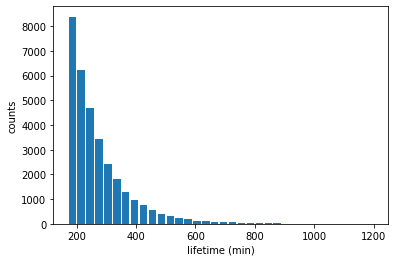

In [67]:
fig_lifetime,ax_lifetime=plt.subplots()
tobac.plot_lifetime_histogram_bar(Tracks,axes=ax_lifetime,bin_edges=np.arange(180,1200,10),density=False,width_bar=25)
ax_lifetime.set_xlabel('lifetime (min)')
ax_lifetime.set_ylabel('counts')
         
plt.savefig(plotdir + 'gpm_lifetime_histogram.png')


The lifetime histogram reveals how frequent long persisting cells (with the previously chosen minimum area of contiguous precipitation) are in comparison to shorter precipitation cells (controlled by the chosen minimum lifetime). Here, we can clearly see that precipitation cells that persist longer than 10 hours (600 min) exhibit only a very small part compared to all tracked cells. 

## Plot tracks with the longest lifetimes

    

In [29]:
# Set extent for maps plotted in the following cells ( in the form [lon_min,lon_max,lat_min,lat_max])
axis_extent=[70.0,105.0,27.0,45.0]        

In [34]:
# returns a subset of cells with a lifetime larger or equal to min_hr  

# parameters: 
# min_hr : minimum of hoursthe cell should prevail (float)
# Tracks: pandas dataframe which is the output of the tobac trajectory linking 


def subset_tracks(Tracks, min_hr):
    durations= []
    long_cells = []
    i = 0 
    for c in np.unique(Tracks.cell):
        duration= (np.shape(Tracks.loc[Tracks.cell == c ])[0])* 0.5
        if duration >= min_hr:
            durations.append(duration)
            long_cells.append(c)
            
    for lc in long_cells:
        if i == 0:
            subset= Tracks.loc[Tracks.cell == lc ]
            i+=1 
        else:
            subset= subset.append(Tracks.loc[Tracks.cell == lc ])
            
    return subset            

In [37]:
min_hr = 15 
subset= subset_tracks(Tracks, min_hr)

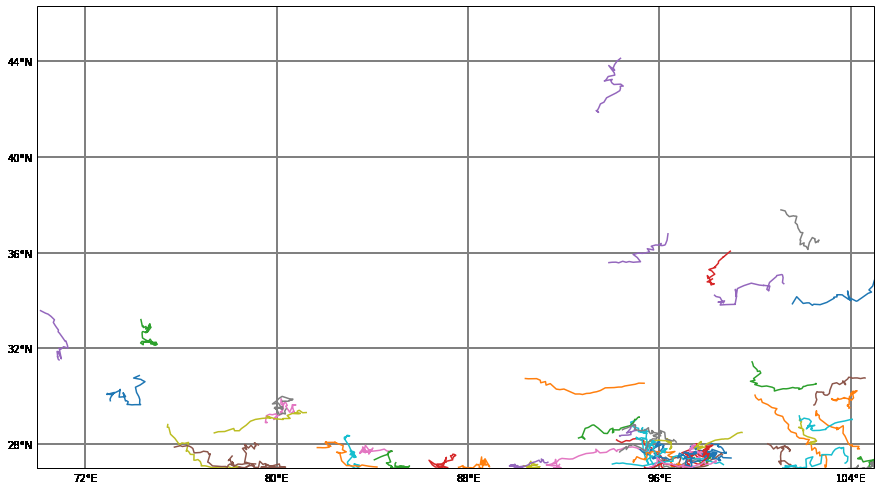

In [51]:
# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(15,15),subplot_kw={'projection': ccrs.PlateCarree()})
ax_map=tobac.map_tracks(subset,axis_extent=axis_extent,axes=ax_map)
plt.savefig(plotdir+ '/tracks_15hr_TP.png')

Plotting the precipitation tracks with the longest lifetimes (here: all cells which last longer than 15 hours), we can see that these storms occur primarily in the south of the Tibetan Plateau. 

# Compare nearest neighbor distance of features with different thresholds

In [ ]:
# calculate minimum distance between neighboring features 
Features_gpm = calculate_nearestneighbordistance(Features, method_distance=None)
Features['min_distance'] /= 1000

In [113]:
# select minimum distance for features containing different thresholds (e.g. 1mm/hr vs. >=10 mm/hr)
heights_gpm, bins_gpm= tobac.nearestneighbordistance_histogram(Features_gpm.loc[Features_gpm.threshold_value == 1], bin_edges = np.linspace(0,2000,100))
heights10_gpm, bins10_gpm= tobac.nearestneighbordistance_histogram(Features_gpm.loc[Features_gpm.threshold_value >= 10], bin_edges = np.linspace(0,2000,100))


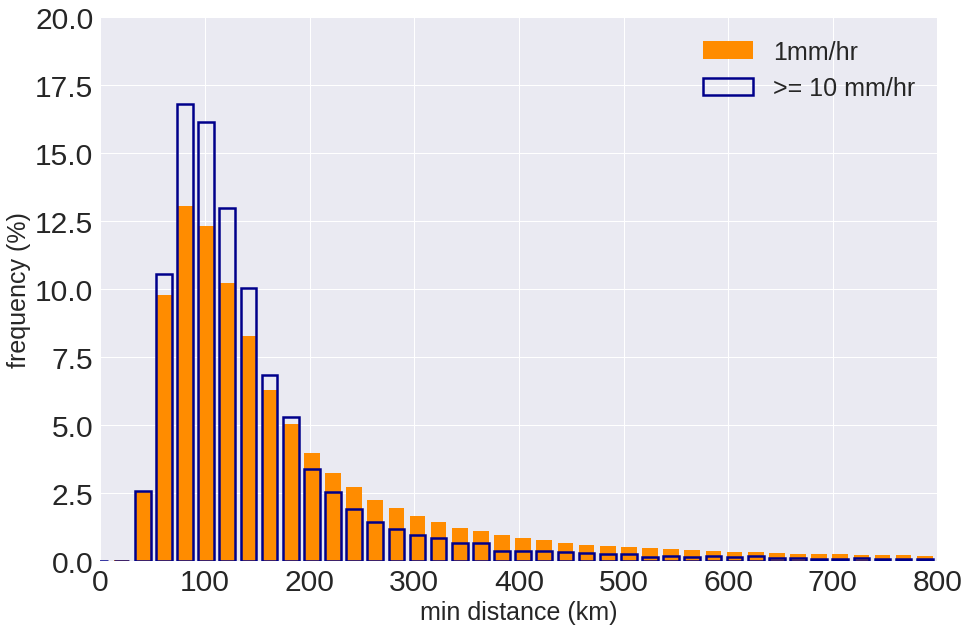

In [115]:
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 30,
             'xtick.labelsize' : 30,'ytick.labelsize' : 30})
plt.figure(figsize=(15, 10))


height_gpm = heights_gpm/np.sum(heights_gpm)
height10_gpm = heights10_gpm/np.sum(heights10_gpm)


plt.bar(bins_gpm[:-1], height_gpm*100, width = 15,color='darkorange',linewidth= 2.5,  label= '1mm/hr')
plt.bar(bins10_gpm[:-1], height10_gpm*100, width = 15, edgecolor='darkblue', color= 'None', linewidth= 2.5,  label= '>= 10 mm/hr')


plt.ylim(0,20)
plt.xlim(0,800)
plt.xlabel('min distance (km)', fontsize= 25)
plt.ylabel('frequency (%)', fontsize = 25)
plt.legend(fontsize= 25)

# save figure to image file 
plt.savefig(plotdir + 'hist_nn_gpm_threshold_high_vs_low.png')

The histograms of nearest neighbor distances show that the most frequent minimum distances lie around 100 km, which indicates a rather sparse distribution of contigous precipitation areas (many isolated precipitation cells). Furthermore, it can be seen that features with the lowest threshold (1mm/hr) tend to be more close to another feature than features with thresholds equal to or larger than 10 mm/hr. This could indicate that meso-scale precipitation features with heavy rain rates tend to occur as rather isolated cells in the Tibetan Plateau region. 

# calculate area with monthly feature and mask chunks

In [101]:
help(tobac.calculate_area)

Help on function calculate_area in module tobac.analysis:

calculate_area(features, mask, method_area=None)



Some functions (like tobac.calculate_area) require the segmentation mask as an input. Whereas the feature chunks can easily be merged together into one dataframe (see above), this is more difficult for the masks into one large iris cube, since the latter would be much larger in size for a high resolution dataset like GPM IMERG. To calculate for example the area for the cells, the best solution is to do it by month, just as the feature detection and segmentation. 

In [5]:
data_dir = '/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/tobac/Save'

In [8]:
# import tracks for GPM 
savedir='/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/tobac/Save'
#file = savedir + '/Tracks_GPM_2014_2017_updatedframes.h5'
file = savedir + '/Tracks_GPM_2014-2017_v_precip.h5'
Tracks = pd.read_hdf(file, 'table')
Tracks['timestr']=pd.to_datetime(Tracks['timestr'],format='%Y-%m-%d %H:%M:%S')

In [6]:
# get file lists with monthly feature and mask chunks 
feature_chunks= glob.glob(data_dir + '/Features_Precip??????.h5')  
feature_chunks.sort()

mask_chunks= glob.glob(data_dir + '/Mask_Segmentation_precip??????.nc')  
mask_chunks.sort()

In [ ]:
features = Tracks
for file in mask_chunks:
    print('calculating area for...', file)
    # read in  mask as iris cube 
    mask=iris.load_cube(file,'segmentation_mask')
    mask.attributes = None    
    features = tobac.calculate_area(features, mask, method_area= 'latlon')
    print('updated track frame.')

    

calculating area for... /media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/tobac/Save/Mask_Segmentation_precip201403.nc
using lats and londs method...


In [179]:
np.max(np.unique(mask.data))
np.max(np.unique(features.index))

941724

In [155]:
features['timestr']=pd.to_datetime(features['timestr'],format='%Y-%m-%d %H:%M:%S')
feat_select= features.loc[features['timestr'].dt.strftime('%Y-%m') == '2014-04']
feat_select

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,longitude,latitude,ncells,cell,time_cell,area
8044,976,26,311.866035,73.451696,15,1,37,2014-04-01 08:30:00,2014-04-01 08:30:00,101.236604,34.295169,16,3899.0,00:00:00,NaN
8054,977,22,309.563594,59.127928,11,1,47,2014-04-01 09:00:00,2014-04-01 09:00:00,101.006360,32.862792,16,3905.0,00:00:00,NaN
8055,977,23,310.411287,86.386645,43,1,48,2014-04-01 09:00:00,2014-04-01 09:00:00,101.091131,35.588665,41,3906.0,00:00:00,NaN
8056,977,24,315.061812,71.830506,15,1,49,2014-04-01 09:00:00,2014-04-01 09:00:00,101.556184,34.133052,14,3899.0,00:30:00,NaN
8063,978,32,311.366880,58.846626,22,1,56,2014-04-01 09:30:00,2014-04-01 09:30:00,101.186689,32.834661,21,3905.0,00:30:00,NaN
8065,978,14,317.124235,71.611591,16,2,58,2014-04-01 09:30:00,2014-04-01 09:30:00,101.762423,34.111160,60,3899.0,01:00:00,NaN
8066,978,8,311.529979,88.606151,14,3,59,2014-04-01 09:30:00,2014-04-01 09:30:00,101.202999,35.810614,21,3906.0,00:30:00,NaN
8071,979,25,315.045281,58.233346,80,1,64,2014-04-01 10:00:00,2014-04-01 10:00:00,101.554531,32.773334,79,3905.0,01:00:00,NaN
8073,979,15,319.365727,71.511830,31,2,66,2014-04-01 10:00:00,2014-04-01 10:00:00,101.986572,34.101183,89,3899.0,01:30:00,NaN
8074,979,3,312.817260,89.732634,12,5,67,2014-04-01 10:00:00,2014-04-01 10:00:00,101.331725,35.923264,33,3906.0,01:00:00,NaN


In [152]:
features

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,longitude,latitude,ncells,cell,time_cell,area
20,3,11,116.924719,8.268390,21,1,21,2014-03-12 01:30:00,2014-03-12 01:30:00,81.742472,27.776839,32,13.0,00:00:00,3.359254e+12
27,4,7,118.296173,8.179100,16,2,28,2014-03-12 02:00:00,2014-03-12 02:00:00,81.879615,27.767910,100,13.0,00:30:00,1.051308e+13
31,5,7,119.479999,7.820160,18,2,32,2014-03-12 02:30:00,2014-03-12 02:30:00,81.998000,27.732016,98,13.0,01:00:00,1.030256e+13
33,6,7,117.147846,5.615235,93,1,34,2014-03-12 03:00:00,2014-03-12 03:00:00,81.764784,27.511523,95,13.0,01:30:00,9.988806e+12
39,7,8,116.765918,3.394934,71,1,40,2014-03-12 03:30:00,2014-03-12 03:30:00,81.726592,27.289494,75,13.0,02:00:00,7.889998e+12
43,8,7,117.720966,1.481708,23,1,44,2014-03-12 04:00:00,2014-03-12 04:00:00,81.822096,27.098170,22,13.0,02:30:00,2.322379e+12
47,9,5,120.552568,1.153616,15,1,48,2014-03-12 04:30:00,2014-03-12 04:30:00,82.105259,27.065361,15,13.0,03:00:00,1.583075e+12
51,10,7,122.040705,0.666947,11,1,52,2014-03-12 05:00:00,2014-03-12 05:00:00,82.254070,27.016694,14,13.0,03:30:00,1.477944e+12
68,30,7,75.456018,57.390703,17,1,69,2014-03-12 15:00:00,2014-03-12 15:00:00,77.595604,32.689071,11,33.0,00:00:00,1.097615e+12
72,31,4,76.016144,57.221102,27,1,73,2014-03-12 15:30:00,2014-03-12 15:30:00,77.651616,32.672111,28,33.0,00:30:00,2.794823e+12


In [147]:
# use contraint time to select specific time frame! 
from iris import Constraint
for time_i, features_i in features.groupby('time'):
    constraint_time = Constraint(time= time_i)
    mask_i= mask.extract(constraint_time)
    print(mask_i.shape)

(351, 181)
(351, 181)
(351, 181)
(351, 181)
(351, 181)
(351, 181)
(351, 181)
(351, 181)
(351, 181)
(351, 181)
(351, 181)
(351, 181)
(351, 181)
(351, 181)
(351, 181)
(351, 181)


KeyboardInterrupt: 

In [115]:
for file in feature_chunks:
    month = file[76:82]
    print('calculating area for...', month)
    # read in features as pandas dataframe
    features = pd.read_hdf(file, 'table')
    if month  == '201403':
        df = features 
    # read in corresponding mask as iris cube 
    m=  data_dir + '/Mask_Segmentation_precip'+ month +'.nc'
    mask=iris.load_cube(m,'segmentation_mask')
    mask.attributes = None    
    features = tobac.calculate_area(features, mask, method_area= 'latlon')
    df = df.append(features)

calculating area for... 201403


KeyboardInterrupt: 